In [6]:
import numpy as np
from numpy import sin, pi, exp, cos
import scipy.fftpack as dft
import pylab
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Решение уравнения Пуассона в прямоугольнике с нулевыми граничными условиями

In [101]:
# lamda возвращает собственные значения разностного оператора Лапласа

# solver принимает на вход cеточную проекцию функции, количество точек Nx, Ny и шаг hx, hy
# и возращает сеточную проекцию решения

def lamda(i, N, h):
    return 4*(sin(pi * i / 2 / N))**2/h**2

def solver(Nx, Ny, hx, hy, fd):
    fd_ft = dft.dstn(fd, norm = "ortho") 
    sol = np.zeros((Nx, Ny), dtype = np.float64) 
    for ix in range(Nx):
        for iy in range(Ny):
            sol[ix, iy] = fd_ft[ix, iy]/(lamda(ix + 1, Nx, hx) + lamda(iy + 1, Ny, hy))
    sol = dft.idstn(sol, norm = "ortho")         
    return sol

## Тест с известным точным решением

<IPython.core.display.Javascript object>


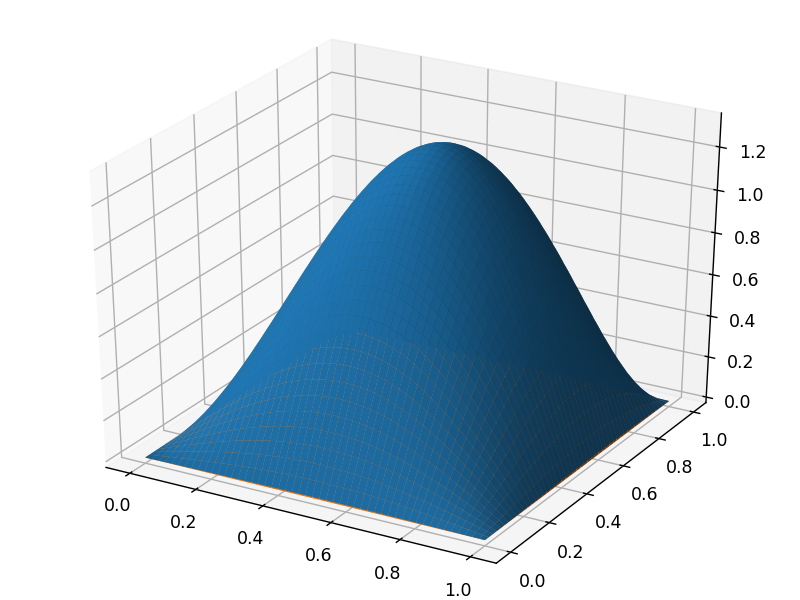

Максимальное отклонение:  0.01091483981608587


In [102]:
# def f(x, y):
#     return sin(pi * x /lx) * sin(pi * y/ly)
def precise_sol(x, y):
    return exp(x * y) * sin(pi * x) * sin(pi * y)
    
def f(x, y):
    return -exp(x * y) * (sin(pi * y) * ((x**2 + y**2 - 2 * pi**2) * sin(pi * x) + 2 * pi * y * cos(pi * x)) + 2 * pi * x * sin(pi * x) * cos(pi * y))

lx = 1; ly = 1
Nx = 250; Ny = 250
x = np.linspace(0, lx, Nx, dtype = np.float64)
y = np.linspace(0, ly, Ny, dtype = np.float64)
hx = x[1] - x[0]
hy = y[1] - y[0]
x, y = np.meshgrid(x, y)

fd = f(x, y).T
# precise_sol =  fd / ((pi/lx) ** 2 + (pi/ly)**2)
precise_sol = precise_sol(x, y).T
numerical_sol = solver(Nx, Ny, hx, hy, fd)

fig = pylab.figure()
axes = Axes3D(fig)

axes.plot_surface(x, y, numerical_sol.T)
axes.plot_surface(x, y, precise_sol.T)
print("Максимальное отклонение: ", np.max(np.abs(numerical_sol - precise_sol)))

## Задание параметров прямоугольника и сетки 

In [55]:
lx = 1; ly = 1
Nx = 320; Ny = 320
x = np.linspace(0, lx, Nx, dtype = np.float64)
y = np.linspace(0, ly, Ny, dtype = np.float64)
hx = x[1] - x[0]
hy = y[1] - y[0]
x, y = np.meshgrid(x, y)

## Задание функции, расчет и построение решения

<IPython.core.display.Javascript object>


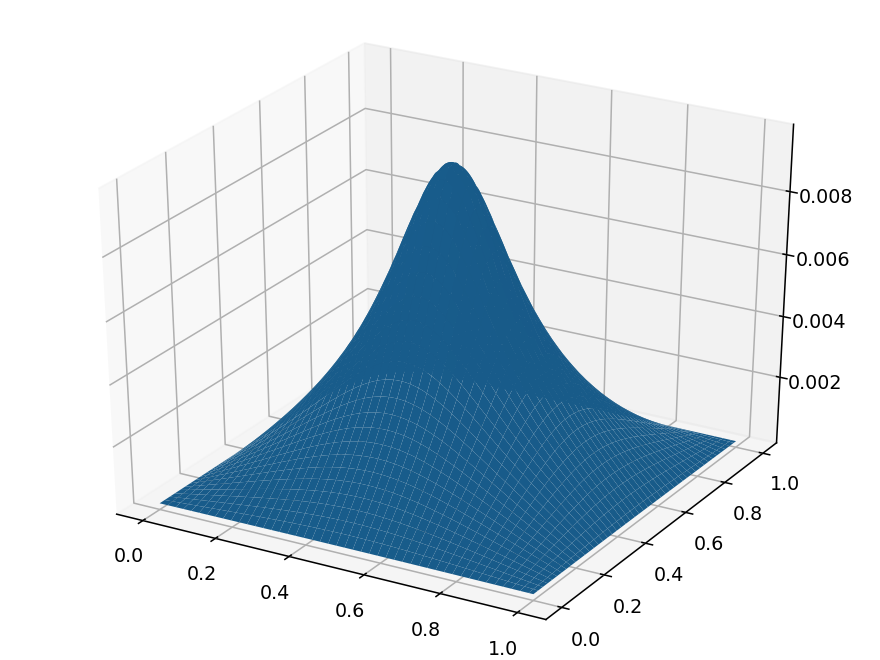

In [56]:
%matplotlib notebook
def f(x, y):
    return exp(-((x - lx/2)**2 + (y - ly/2)**2)/0.1**2)

fd = f(x, y).T
sol = solver(Nx, Ny, hx, hy, fd)

fig = pylab.figure()
axes = Axes3D(fig)

axes.plot_surface(x, y, sol.T)
# axes.plot_surface(x, y, fd)


In [51]:
U4h = sol.copy()

In [54]:
U2h = sol.copy()

In [57]:
Uh = sol.copy()

In [66]:
U2h[1:-1:2, 1:-1:2].shape

(79, 79)

In [77]:
p = np.max(np.abs(Uh[::4, ::4] - U2h[::2, ::2]))/np.max(np.abs(U4h- U2h[::2, ::2]))

In [79]:
np.log2(1/p)

1.0211920385325302

# Решение уравнения Пуассона с другими граничными условиями

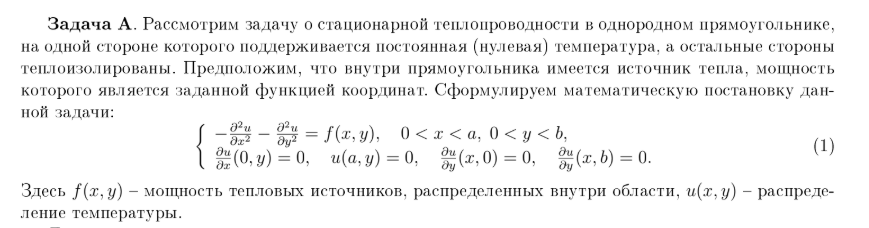

In [2]:
# Метод Гаусса для трехдиагональных матриц будет тут
# прогонка для а * у _(n-1) - b * y_n + c * y_(n+1) = d
# a_0 = 0!!!
def TDMA(a, b, c, d):
    
    y = [0] * len(b) 
    a = list(a)
    b = list(b)
    c = list(c)
    d = list(d)
    
    if( b[0] == 0 ):
        
        y[1] = d[0]/c[0]
        d[1] = b[1] * y[1] + d[1]
        d[2] = d[2] - a[2] * y[1]
        b[1] = - a[1]
        a[1] = 0; a[2] = 0
        b = b[1:]; a = a[1:]; c = c[1:]; d = d[1:]
        x = TDMA(a, b, c, d)
        y[0] = x[0]
        for i in range(1,len(x)):
            y[i+1] = x[i]
    
    else:      
        P = []
        Q = []
        P.append(0)
        Q.append(0)
        if(b[0] == 0):
            print("Strange")
        P.append(c[0]/b[0])
        Q.append(-d[0]/b[0])
    #     print(P[1], Q[1])

        for n in range(1, len(b)):
            P.append(c[n] / (b[n] - a[n]* P[n]))
            Q.append((a[n] * Q[n] - d[n])/(b[n] - a[n] * P[n]))


        k = len(b) - 1
        y[k] = (a[k] * Q[k] - d[k])/(b[k] - a[k] * P[k])

        for n in reversed(range(len(b)-1)):
            y[n] = P[n+1] * y[n+1] + Q[n+1]
    
    return np.array(y)

In [3]:
def lamda(i, N, h):
    return 4*(sin(pi * i / 2 / N))**2/h**2

def solver(Nx, Ny, hx, hy, fd):
    fd_fty = dft.dct(fd, axis = 1, type = 2, norm = "ortho")
    sol = np.zeros((Nx, Ny), dtype = np.float64)
    a = np.zeros(Nx, dtype = np.float64)
    a[1:] = -1/hx**2 
    c = np.zeros(Nx, dtype = np.float64)
    c[:-1] = -1/hx**2   
    for m in range(Ny):
        d = np.zeros(Nx, dtype = np.float64)
        b = np.zeros(Nx, dtype = np.float64)
        b[:] = -(2/hx**2 + lamda(m, Ny, hy))
        d = fd_fty[:, m]
        b[0] = 1; c[0] = 1; d[0] = 0
        b[-1] = 1; d[-1] = 0; c[-1] = 0; a[-1] = 0
        sol[:, m] = TDMA(a, b, c, d)

    sol = dft.idct(sol, axis = 1, type = 2, norm = "ortho")
    return sol

## Тест с известным точным решением

0.022064363349503235


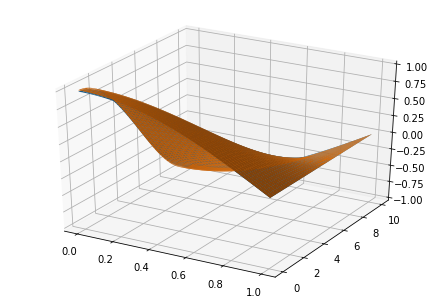

In [20]:
def f(x, y):
    return ((pi/2/lx)**2 + (pi/ly)**2)* cos(pi * x / 2 / lx) * cos(pi * y / ly) 

def precise_sol(x, y):
    return cos(pi * x / 2 / lx) * cos(pi * y / ly) 

lx = 1; ly = 10
Nx = 50; Ny = 50
x = np.linspace(0, lx, Nx)
y = np.linspace(0, ly, Ny)
hx = x[1] - x[0]
hy = y[1] - y[0]
x, y = np.meshgrid(x, y)

fd = f(x, y).T
numerical_solution = solver(Nx, Ny, hx, hy, fd)
precise_solution = precise_sol(x, y).T

fig = pylab.figure()
axes = Axes3D(fig)

axes.plot_surface(x, y, numerical_solution.T)
axes.plot_surface(x, y, precise_solution.T)
print(np.max(np.abs(numerical_solution - precise_solution)))

##  Сама задача А

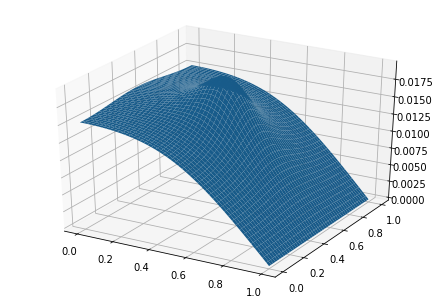

In [4]:
#источник
def f(x, y):
    return exp(-((x - lx/2)**2 + (y - ly/2)**2)/0.1**2)

#параметры прямоугольника и сетки
lx = 1; ly = 1
Nx = 200; Ny = 200
x = np.linspace(0, lx, Nx, dtype = np.float64)
y = np.linspace(0, ly, Ny, dtype = np.float64)
hx = x[1] - x[0]
hy = y[1] - y[0]
x, y = np.meshgrid(x, y)

#расчет
fd = f(x, y).T
numerical_solution = solver(Nx, Ny, hx, hy, fd)

#построение точного решения
fig = pylab.figure()
axes = Axes3D(fig)
axes.plot_surface(x, y, numerical_solution.T)